In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

print('TF version: ', tf.__version__)
print('TFP version: ', tfp.__version__)

TF version:  2.4.1
TFP version:  0.12.1


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

#### Create data

The data we'll be working with is artificially created from the following equation:

$$y_i = x_i + \frac{3}{10}\epsilon_i$$

where $\epsilon_i \sim \mathcal{N}(0,1)$ are independent and identically distributed

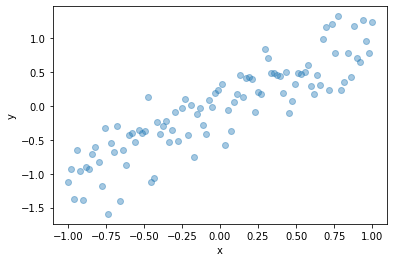

In [4]:
# Create and plot 100 points of training data

x_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = x_train + 0.3*np.random.randn(100)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Deterministic linear regression with MSE loss

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


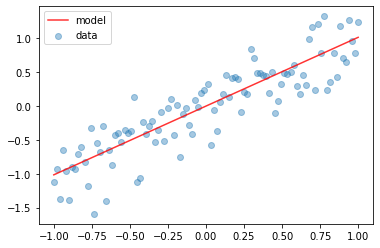

In [6]:
# Create and train deterministic linear model using mean squared error loss

# Create linear regression via Sequential model

model = Sequential([
    Dense(units=1, input_shape=(1,)),
])
model.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model.summary()
model.fit(x_train, y_train, epochs=200, verbose=False)

# Plot the data and the model
plt.scatter(x_train, y_train, alpha=0.4, label='data')
plt.plot(x_train, model.predict(x_train), color='red', alpha=0.8, label='model')
plt.legend()
plt.show()

In [8]:
# Examine the model predictions

x = np.array([[0]])
y_model = model(x)
y_model

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00296079]], dtype=float32)>

The deterministic linear regression fails to capture the aleatoric uncertainty (uncertainty on the process generation of the data). We can see this by the output above, where we get the y_value (our prediction) but we don't get any reference to the uncertainty of that prediction (there is significant uncertainty as we can see from the distance between the blue points and the red line).

#### Probabilistic linear regression to model the aleatoric uncertainty

In [11]:
# Create probabilistic regression with normal distribution as final layer

model = Sequential([
    Dense(units=1, input_shape=(1,)),
    tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc=t, scale=1)))
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1)                 2         
_________________________________________________________________
distribution_lambda_1 (Distr multiple                  0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Train model using the negative loglikelihood

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [14]:
model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.fit(x_train, y_train, epochs=100, verbose=False)

In [15]:
# Examine the distribution created as a feedforward value

y_model = model(x)
y_model

<tfp.distributions.Independent 'sequential_3_distribution_lambda_1_Independentsequential_3_distribution_lambda_1_Normal' batch_shape=[1] event_shape=[1] dtype=float32>

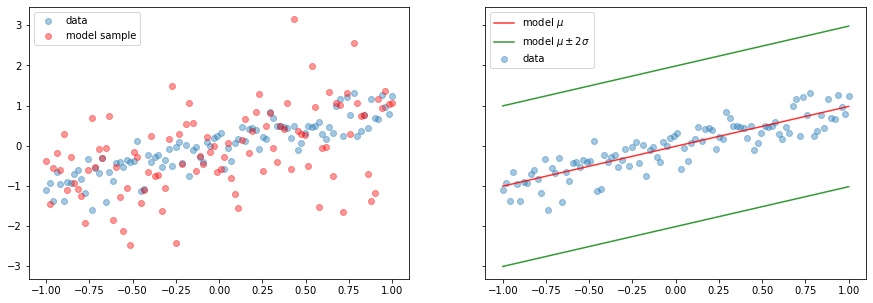

In [18]:
# Plot the data and a sample from the model

y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat -2 * y_sd
y_hat_p2sd = y_hat + 2*y_sd

fig, (ax1, ax2) =plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.4, label='data')
ax1.scatter(x_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.4, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

As we can see we capture the mean correctly but as we did not infer the standard deviation (it was input by us) we see that its value is far from correct. Let's add the standard deviation as a parameter of the model.

In [23]:
# Create probabilistic regression with normal distribution as final layer

event_shape = 1

model = Sequential([
    Dense(units=tfpl.IndependentNormal.params_size(event_shape), input_shape=(1,)),
    tfpl.IndependentNormal(event_shape=1)
    # We could also define as:
    # tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc=t[...,:1], scale=tf.math.softplus(t[...,1:]))))
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 2)                 4         
_________________________________________________________________
independent_normal_1 (Indepe multiple                  0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Train model using the negative loglikelihood

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [28]:
model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.fit(x_train, y_train, epochs=200, verbose=False)

In [29]:
# Examine the distribution created as a feedforward value

y_model = model(x)
y_model

<tfp.distributions.Independent 'sequential_7_independent_normal_1_IndependentNormal_Independentsequential_7_independent_normal_1_IndependentNormal_Normal' batch_shape=[1] event_shape=[1] dtype=float32>

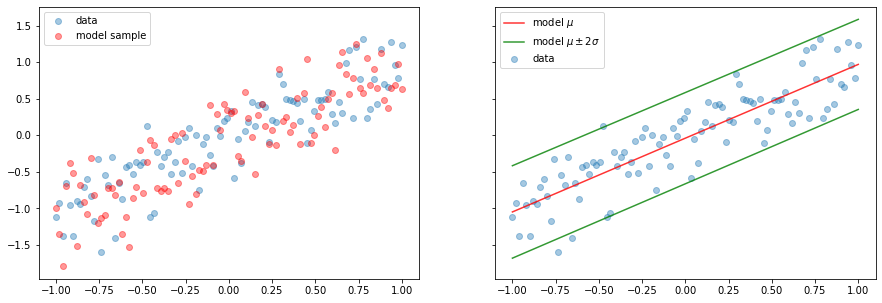

In [30]:
# Plot the data and a sample from the model

y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat -2 * y_sd
y_hat_p2sd = y_hat + 2*y_sd

fig, (ax1, ax2) =plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.4, label='data')
ax1.scatter(x_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.4, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

#### Probabilitistic linear regression with nonlinear learned mean & variance

Let's change the data to being nonlinear:

$$y_i = x_i^3+\frac{1}{10}(2+x_i)\epsilon_i$$

where $\epsilon_i \sim \mathcal{N}(0,1)$ are independent and identically distributed.

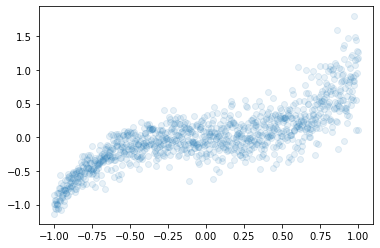

In [31]:
# Create and plot 10000 data points

x_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(x_train, 3) + 0.1*(2+x_train)*np.random.randn(1000)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.1)
plt.show()

In [33]:
# Create probabilistic regression: normal distribution with fixed variance

model = Sequential([
    Dense(input_shape=(1,), units=8, activation='sigmoid'),
    Dense(tfpl.IndependentNormal.params_size(event_shape=1)),
    tfpl.IndependentNormal(event_shape=1)
])

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.01))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 8)                 16        
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 18        
_________________________________________________________________
independent_normal_2 (Indepe multiple                  0         
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Train model

model.fit(x_train, y_train, epochs=200, verbose=False)
model.evaluate(x_train, y_train)

32/32 [==============================] - 0s 529us/step - loss: -0.1695


-0.1694745421409607

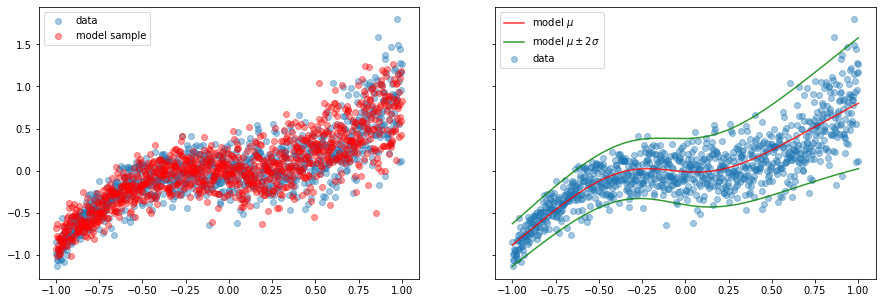

In [35]:
# Plot the data and a sample from the model

y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat -2 * y_sd
y_hat_p2sd = y_hat + 2*y_sd

fig, (ax1, ax2) =plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.4, label='data')
ax1.scatter(x_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.4, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()